In [1]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import NeptuneLogger
from torchmetrics.functional import dice_score 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib
from pytorch_lightning import seed_everything
import os
#from pytorch_lightning.plugins import DDPPlugin

from model import UNet
seed_everything(seed=42)

Global seed set to 42


42

In [2]:
def dice_loss(inputs, target):
    smooth = 1.

    iflat = inputs.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))


# Load in the data

In [3]:
train=pd.read_csv('train.csv')
val=pd.read_csv('val.csv')
trainlist=tuple(zip(train['input_file_path'].values,train['Parcellation'].values))
vallist=tuple(zip(val['input_file_path'].values,val['Parcellation'].values))
train_subjects=[]
val_subjects=[]

#Scalar Image


for subject_path in trainlist:
    subject = tio.Subject({"MRI":tio.ScalarImage(subject_path[0]), "Label":tio.LabelMap(subject_path[1])})
    train_subjects.append(subject)

for subject_path in vallist:
    subject = tio.Subject({"MRI":tio.ScalarImage(subject_path[0]), "Label":tio.LabelMap(subject_path[1])})
    val_subjects.append(subject)

In [5]:
train_subjects

[Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(Keys: ('MRI', 'Label'); images: 2),
 Subject(K

In [6]:
subject['Label'].data.unique()

tensor([   0.,    4.,    6.,    7.,   10.,   11.,   12.,   13.,   14.,   15.,
          16.,   17.,   18.,   24.,   28.,   43.,   45.,   46.,   49.,   50.,
          51.,   52.,   53.,   54.,   60.,  630.,  631.,  632., 1002., 1003.,
        1005., 1006., 1007., 1008., 1009., 1010., 1011., 1012., 1013., 1014.,
        1015., 1016., 1017., 1018., 1019., 1020., 1021., 1022., 1023., 1024.,
        1025., 1026., 1027., 1028., 1029., 1030., 1031., 1034., 1035., 2002.,
        2003., 2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
        2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.,
        2024., 2025., 2026., 2027., 2028., 2029., 2030., 2031., 2034., 2035.])

# Setup Preprocessing augmentations 

In this section there are alot of options i could rotate, flip, defrom, change the ratio at which I do that

In [7]:
remapp=pd.read_pickle('mapping.pkl')

process = tio.Compose([
            tio.CropOrPad((192, 192, 192)), #This crops it to the desired metirc
            tio.RescaleIntensity((-1, 1)), # This normalizes the data
            tio.RemapLabels(remapp)
            ])




#augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10)) #original augmentation 

spatial_transforms = {
    tio.RandomElasticDeformation(): 0.2,
    tio.RandomAffine(scales=(0.9, 1.1), degrees=(-20, 20)): 0.8,
}
augmentation = tio.Compose([
    tio.OneOf(spatial_transforms, p=0.5),
   ])



##Actual Augmentation process
val_transform = process
train_transform = tio.Compose([process, augmentation])

# So when I am using cross entropy loss I need to have conitnous 0-n-1 classes since there are 90 classes with labels up to 2000+ this is throwing an error I had to fix it with remap labels library in tio

In [7]:
train_dataset = tio.SubjectsDataset(train_subjects, transform=train_transform)
val_dataset = tio.SubjectsDataset(val_subjects, transform=val_transform)

In [47]:
len(train_dataset)

1158

## I would like to get a large batch size but I may have to contend with patching and sampling from the patches Ill impliment this later to see if it increases results

In [8]:
batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)


In [9]:
subject['MRI']

ScalarImage(shape: (1, 182, 218, 182); spacing: (1.00, 1.00, 1.00); orientation: LAS+; path: "/home2/wamri/brainlabs/Brainwork/input_mri/input_files/sub-ADNI137S1426_ses-M12_T1w.nii")

In [11]:
img = subject["MRI"]["data"]
mask = subject["Label"]["data"][:,0]

<function __main__.dice_loss(inputs, target)>

In [ ]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4,weight_decay=1e-6)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        img = batch["MRI"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        pred = self(img)
    #    preds = torch.argmax(pred, 1)
     #   print('Dice loss',dice_loss(preds,mask))
        print('Cross Entropy',self.loss_fn(pred, mask))
        loss = self.loss_fn(pred, mask
        #Got here
        dice_sc = dice_score(pred,mask)
        print(f'Dice Score: {dice_sc}')
        print(f'train loss: {loss.item()}')
        self.log('Dice loss',dice_sc)
        # Logs
        self.log("Train Loss", loss.item())
        if batch_idx % 50 == 0:
            names=[i.split('/')[-1] for i in batch['MRI']['path']]
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train",names)
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        img = batch["MRI"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Loss", loss.item())
        names=[i.split('/')[-1] for i in batch['MRI']['path']]
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val",names)
        print(f'val loss: {loss.item()}')
        
        return loss

    
    def log_images(self, img, pred, mask, name, file_names):
        
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 100  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth \n"+file_names[0],wrap=True)
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Prediction")
        self.logger.experiment[f"{name} Prediction vs Label"].log(File.as_image(fig))
        #plt.close('all')
    
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]
    
#Possible learning rate schedulars 

#     def configure_optimizers(self):
#         self.opt1 = torch.optim.Adam(self.model.parameters(), lr=1e-4)
#         self.opt2 = torch.optim.SGD(self.model.parameters(), lr=1e-4, momentum=0.9)
#         optimizers = [opt1, opt2]
#         lr_schedulers = {"scheduler": ReduceLROnPlateau(opt1, 'min'), "monitor": "metric_to_track"}
#         return optimizers, lr_schedulers

In [ ]:
model = Segmenter()

# Test if you brok your model

In [ ]:
train_features= next(iter(train_loader))

In [ ]:
model.training_step(train_features,1)

AttributeError: 'NoneType' object has no attribute 'experiment'

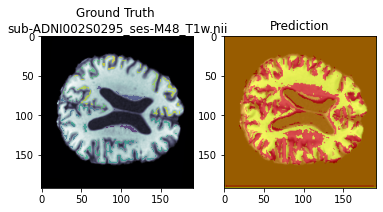

In [79]:
model.validation_step(train_features,1)

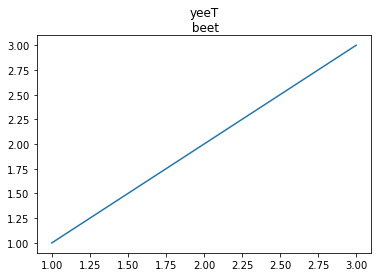

In [69]:
x=[1,2,3]
y=[1,2,3]
plt.plot(x,y)
plt.title('yeeT\n beet',wrap=True)
plt.show()

In [21]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')


#check this cell
#Ssave name of brains

In [22]:
# trainer = pl.Trainer(
#     fast_dev_run = True,
#     gpus=[3], 
#     #auto_select_gpus=True,
#     #auto_lr_find=True,
#     #strategy='dp',
#     log_every_n_steps=1,
#     precision=16,
#     #deterministic=True,
#     #plugins=DDPPlugin(find_unused_parameters=False),
#     callbacks=[checkpoint_callback],
#     min_epochs= 50,
#     max_epochs = 100,
#     logger=TensorBoardLogger(save_dir="./logs")
# )# 

SyntaxError: unexpected EOF while parsing (45777448.py, line 15)

In [2]:
!pwd

/home2/wamri/brainlabs/Brainwork/workfiles


In [25]:
gpus =1  #
logger=CSVLogger("logs", name="my_exp_name")
trainer = pl.Trainer(gpus=gpus, logger=logger, log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 5.8 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.356    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/jott2/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


we are moving forward?


/home/jott2/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


we are moving forward?


/home/jott2/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

we are training?
we are moving forward?


RuntimeError: CUDA out of memory. Tried to allocate 2.37 GiB (GPU 0; 23.65 GiB total capacity; 10.70 GiB already allocated; 2.33 GiB free; 11.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

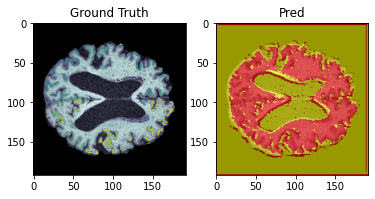

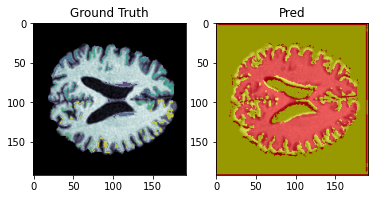

In [26]:
trainer.fit(model, train_loader, val_loader)